# Modeling: Regression
- Use n-1 year on-field stats and n year for talent stats to predict year n results
- Treat data as set of features at start of each year and try to regress on various outcomes

In [10]:
!pip install --q xgboost

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [13]:
df = pd.read_csv('data/working_df.csv')
df.head()

,team,team_id,year,conference,games_played,expected_wins,wins,losses,win_pct,prev_win_pct,...,usages,off_drives,def_drives,off_explode,def_explode,off_ppa,def_ppa,off_success_rate,def_success_rate,coach
0,Air Force,2005,2014,Mountain West,13,9.7,10,3,0.769231,0.166667,...,0.684,139,137,0.860561,0.902638,0.096601,0.214295,0.439644,0.518913,Troy Calhoun
1,Air Force,2005,2015,Mountain West,14,8.2,8,6,0.571429,0.769231,...,0.646,165,161,1.089935,1.425767,0.207059,0.138795,0.451837,0.375831,Troy Calhoun
2,Air Force,2005,2016,Mountain West,13,9.4,10,3,0.769231,0.571429,...,0.625,177,173,1.154045,1.549206,0.272449,0.172654,0.474216,0.357631,Troy Calhoun
3,Air Force,2005,2017,Mountain West,12,4.4,5,7,0.416667,0.769231,...,0.556,147,148,1.027586,1.534094,0.227697,0.158770,0.483333,0.366048,Troy Calhoun
4,Air Force,2005,2018,Mountain West,12,6.4,5,7,0.416667,0.416667,...,0.720,138,139,1.095699,1.374592,0.235542,0.247661,0.488398,0.422096,Troy Calhoun


In [14]:
df.columns

Index(['team', 'team_id', 'year', 'conference', 'games_played',
       'expected_wins', 'wins', 'losses', 'win_pct', 'prev_win_pct', 'elo',
       'fpi', 'conference_rating', 'recruiting_rank', 'points', 'blue_chip',
       'blue_chip_ratio', 'passing_usage', 'rushing_usage', 'usages',
       'off_drives', 'def_drives', 'off_explode', 'def_explode', 'off_ppa',
       'def_ppa', 'off_success_rate', 'def_success_rate', 'coach'],
      dtype='object')

#### Feature Selection

- Can't include coach_win_pct when doing regression

In [15]:
# Grab features and target
X = df[['elo', 'fpi', 'conference_rating', 'recruiting_rank', 'points', 'prev_win_pct', 
        'blue_chip_ratio', 'usages', 'off_ppa', 'off_success_rate', 'passing_usage']]
y = df['win_pct']

We need to scale our features

In [16]:
from sklearn.preprocessing import StandardScaler

X_scaled = X.copy()

# Scale data, retaining original column titles and structure
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_scaled), columns = X_scaled.columns)

# Recombine data with the one hot encoded columns
X_scaled.head()

,elo,fpi,conference_rating,recruiting_rank,points,prev_win_pct,blue_chip_ratio,usages,off_ppa,off_success_rate,passing_usage
0,-1.516328,-1.455326,-0.904361,1.263752,-1.426661,-1.597520,-0.652648,0.389082,-0.820942,0.225061,0.417201
1,-0.271573,-0.311668,-0.852612,1.551575,-1.422362,1.141217,-0.652648,0.205003,0.357773,0.503852,-1.089781
2,0.076682,0.047703,-0.770595,1.316083,-1.191650,0.242179,-0.652648,0.103275,1.055562,1.015552,-1.133276
3,0.283566,-0.030580,-0.760831,1.185254,-1.102446,1.141217,-0.652648,-0.230975,0.577999,1.224010,1.021018
4,-0.306054,-0.659762,-1.042033,1.525410,-1.198636,-0.461236,-0.652648,0.563473,0.661718,1.339809,0.742136


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X_scaled.copy(), y.copy(), random_state=123)
rf = RandomForestRegressor(n_estimators=500, max_depth=4)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=500)

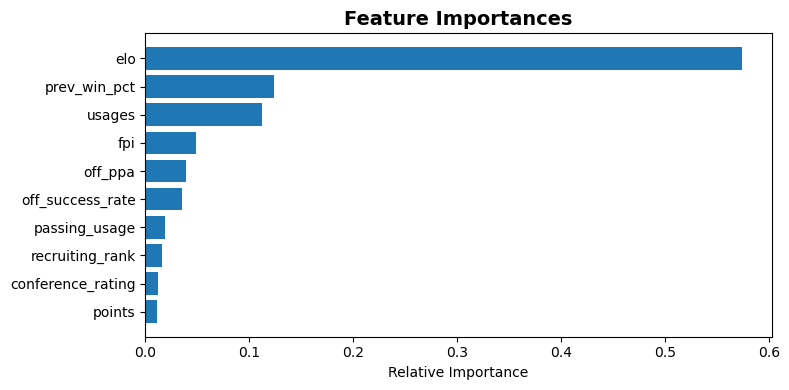

In [19]:
# Use my premade method for graphing feature importance
def graph_feature_importance(model, data):
    """
    model = trained model object from sklearn
    data = Usually X_train
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:] # Get top 10 most important features
    features = data.columns
    f, ax = plt.subplots(figsize=(8, 4))
    plt.title('Feature Importances', fontweight='bold', fontsize=14)
    plt.barh(range(len(indices)), importances[indices])#, color = colormap.colors)
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig('images/feature_imporances.png')
    plt.show()

graph_feature_importance(rf, X_train)

### BELOW IS IN PROGRESS

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [23]:
# Make kfold object
kfold = KFold(5, random_state=123, shuffle=True)

mses = np.zeros((5,5))
i = 0
for i, (train_index, test_index) in enumerate(kfold.split(X_train)):

    X_tt, y_tt = X_train.iloc[train_index], y_train.iloc[train_index]
    X_ho, y_ho = X_train.iloc[test_index], y_train.iloc[test_index]

    # Baseline model, take previous winning percentage
    pred0 = X_ho['prev_win_pct']

    # Declare Models
    model1 = LinearRegression() # All features
    model2 = LinearRegression() # Most relevant
    model3 = RandomForestRegressor()
    model4 = XGBRegressor()

    # Train Models
    model1.fit(X_tt, y_tt)
    model2.fit(X_tt[['elo', 'prev_win_pct', 'usages', 'fpi', 'off_ppa']], y_tt)
    model3.fit(X_tt, y_tt)
    model4.fit(X_tt, y_tt)

    # Get predictions
    pred1 = model1.predict(X_ho)
    pred2 = model2.predict(X_ho[['elo', 'prev_win_pct', 'usages', 'fpi', 'off_ppa']])
    pred3 = model3.predict(X_ho)
    pred4 = model4.predict(X_ho)

    mses[0,i] = mean_squared_error(y_ho, pred0)
    mses[1,i] = mean_squared_error(y_ho, pred1)
    mses[2,i] = mean_squared_error(y_ho, pred2)
    mses[3,i] = mean_squared_error(y_ho, pred3)
    mses[4,i] = mean_squared_error(y_ho, pred4)
    

In [25]:
np.mean(mses, axis=1)

array([1.08754662, 0.02814796, 0.02869853, 0.02743373, 0.03233741])

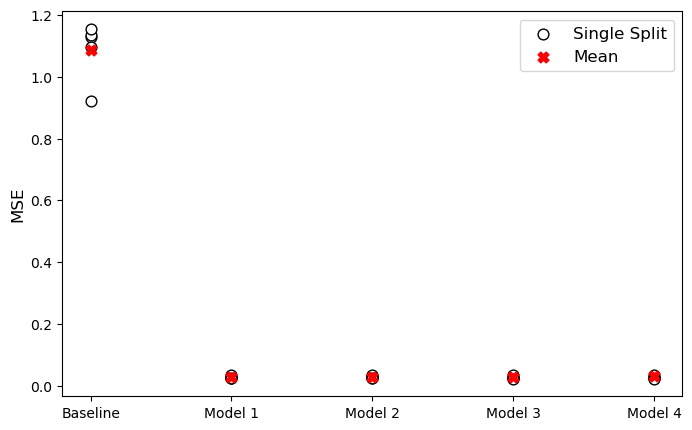

In [24]:
## This figure will compare the performance
plt.figure(figsize=(8,5))

plt.scatter(np.zeros(5), 
            mses[0,:], 
            s=60, 
            c='white',
            edgecolor='black',
            label="Single Split")
plt.scatter(np.ones(5), 
            mses[1,:], 
            s=60, 
            c='white',
            edgecolor='black')
plt.scatter(2*np.ones(5), 
            mses[2,:], 
            s=60, 
            c='white',
            edgecolor='black')

plt.scatter(3*np.ones(5), 
            mses[3,:], 
            s=60, 
            c='white',
            edgecolor='black')

plt.scatter(4*np.ones(5), 
            mses[3,:], 
            s=60, 
            c='white',
            edgecolor='black')

plt.scatter([0,1,2,3,4], 
            np.mean(mses, axis=1), 
            s=60, 
            c='r',
            marker='X',
            label="Mean")

plt.legend(fontsize=12)

plt.xticks([0,1,2,3, 4],["Baseline", "Model 1", "Model 2", "Model 3", "Model 4"], fontsize=10)
plt.yticks(fontsize=10)

plt.ylabel("MSE", fontsize=12)

plt.show()